This is a notebook that computes and scans soliton-only model.
Instead of notebook 2, I use bisection on $M_{\rm sol}$ to get the bound 
corresponding to a specific $\chi^2$. 

# Init

In [1]:
from __future__ import division

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.integrate import quad
import h5py
import glob
import re
import os

import scan
import pickle
import glob
from multiprocessing import Pool
from contextlib import closing

from matplotlib import cm
from tqdm import tqdm

from multiprocessing import Pool
from contextlib import closing
from scipy.optimize import root_scalar

In [50]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import spc
import model
import chi2
import margin
import tools as tl
import scan_bis

In [6]:
from matplotlib import rcParams
#rcParams["font.family"] = "Times New Roman"
rcParams['font.size'] = 14

In [7]:
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [8]:
path = '../data/SPARC.txt'
data = spc.readSPARC(path)

path = '../data/SPARC_Lelli2016c.txt'
spc.readSPARC_ext(data, path)

In [9]:
data2 = {}
for gal in data:
    data2[gal.name] = gal

# Bisection

In [73]:
scanner = scan_bis.Scanner_bis()

def f(gal):
    scanner.scan(gal, 
                 num_of_log_m=50, #50, #20
                 dir_name='results_bisection_04',
                 debug=False)

# map(f, data[0:1])
with closing(Pool()) as pool:
    pool.map(f, data)
    pool.terminate()


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


<IPython.core.display.Javascript object>


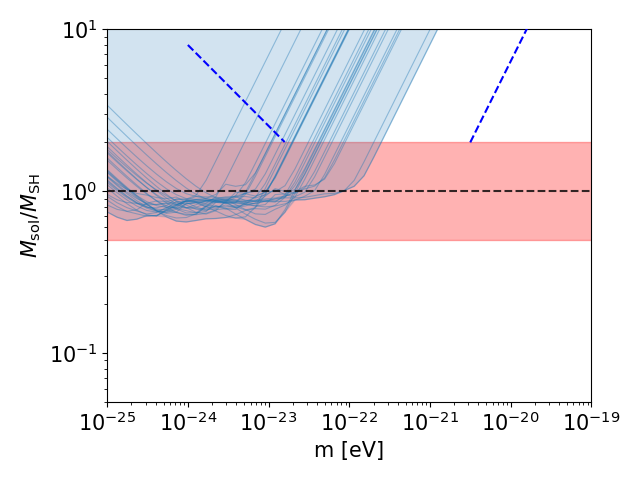

../../results_bisection_04/result-NGC7814.dat
M: 2.91e+14
../../results_bisection_04/result-UGC08699.dat
M: 3.28e+14
../../results_bisection_04/result-NGC3726.dat
M: 3.79e+14
../../results_bisection_04/result-NGC2841.dat
M: 1.30e+15
../../results_bisection_04/result-UGC06973.dat
M: 9.85e+13
../../results_bisection_04/result-NGC4013.dat
M: 3.68e+14
../../results_bisection_04/result-UGC02487.dat
M: 1.87e+15
../../results_bisection_04/result-NGC2683.dat
M: 3.64e+14
../../results_bisection_04/result-NGC5371.dat
M: 6.87e+14
../../results_bisection_04/result-NGC0289.dat
M: 8.18e+14
../../results_bisection_04/result-UGC05253.dat
M: 8.10e+14
../../results_bisection_04/result-UGC03546.dat
M: 3.93e+14
../../results_bisection_04/result-NGC4100.dat
M: 2.52e+14
../../results_bisection_04/result-UGC02916.dat
M: 4.79e+14
../../results_bisection_04/result-NGC0891.dat
M: 2.48e+14
../../results_bisection_04/result-NGC3992.dat
M: 7.60e+14
../../results_bisection_04/result-NGC3953.dat
M: 2.35e+14
../../re

28

In [148]:
bound_dct = {}
bound_range_dct = {}

plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel(r'$M_{\rm sol}/M_{\rm SH}$')
plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1
counter = 0

# check correlation between Msol/MSH with Mgalaxy
M_gal_arr = []
ratio_min_arr = []
Msol_min_arr = []

# specially selected ones
M_gal_sel_arr = []
ratio_min_sel_arr = []
Msol_min_sel_arr = []

path_wild = '../../results_bisection_04/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        #scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                print('hit')
                continue            
            m = result.m
            M = result.M_arr[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
                  
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        
        # log the min of ratio
        ratio_min_arr.append(min(ratio_arr))
        Msol_min_arr.append(M_plt_arr[np.argmin(ratio_arr)])
        gal = spc.findGalaxyByName(res_arr[0].gal.name, data)
        M_gal_arr.append(gal.get_M())
        # end of logging
        
#         if result.gal.name != "UGC12732":
#             continue

        # debug
        if m_plt_arr[np.argmin(ratio_arr)] > 1e-23:
            continue     
        print(path)
        counter += 1
        
        ## print gal MSH, Mvirial
        print("M: %.2e" %(gal.get_M()))
        # select ratio
        ratio_min_sel_arr.append(min(ratio_arr))
        
        # select absolute value of Msol
        Msol_min_sel_arr.append(M_plt_arr[np.argmin(ratio_arr)])        
        gal = spc.findGalaxyByName(res_arr[0].gal.name, data)
        
        # sel M gal
        M_gal_sel_arr.append(gal.get_M())        
        
        # gubed
        
        mask = ratio_arr < ratio_upper * 10
        plt.plot(m_plt_arr[mask], ratio_arr[mask], lw='0.8', color='C0', alpha=0.4)
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)
        
        # log the range of m where SH is in tension with SPARC:
        def func(m):
            return np.interp(np.log10(m), np.log10(m_plt_arr), ratio_arr, left=np.nan, right=np.nan)
        def root1(log10m):
            return func(10**log10m) - 1.
        def root05(log10m):
            return func(10**log10m) - 0.5
        def root2(log10m):
            return func(10**log10m) - 2.
        
        try:
            m_up_sol = root_scalar(root1, method='bisect', bracket=[np.log10(m_plt_arr)[np.argmin(ratio_arr)], np.log10(m_plt_arr)[-1]])
            m_low_sol = root_scalar(root1, method='bisect', bracket=[np.log10(m_plt_arr)[np.argmin(ratio_arr)], np.log10(m_plt_arr)[0]])
            #print(m_up)
        except ValueError:
            continue
        bound_range_dct[result.gal.name] = (m_low_sol, m_up_sol)            
#         # plot out the contour to check
#         mask1 = np.where(m_plt_arr > 10**m_low_sol.root, True, False)
#         mask2 = np.where(m_plt_arr < 10**m_up_sol.root, True, False)
#         mask = mask1 * mask2
#         plt.plot(m_plt_arr[mask], ratio_arr[mask], lw='0.8', color='C0', alpha=0.4)

# the joint bound
plt.fill_between(m_plt_arr, M_joint_arr, 10, color='C0', alpha=0.2)
bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.3, color='r', zorder=0.1)
plt.plot(x, y, 'k--', alpha=0.8)

m_test = np.logspace(-24, -22.8)
M_test = 8*(m_test/1e-24)**(-1/2)
plt.plot(m_test, M_test, '--', color='b', zorder=5)

m_test = np.logspace(-20.5, -19)
M_test = 2.*(m_test/m_test[0])
plt.plot(m_test, M_test, '--', color='b', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

counter

#plt.savefig('./plots/sol_full_SPARC_2sigma.pdf')
#plt.savefig('./plots/sol_full_SPARC_2sigma_talk_1.pdf', facecolor=(256/256.,252/256.,244/256.))
#plt.savefig('./plots/sol_full_SPARC_2sigma_talk.pdf', facecolor=(256/256.,252/256.,244/256.))

In [ ]:
# correlation of Msol/MSH w.r.t Mgalaxy

<IPython.core.display.Javascript object>


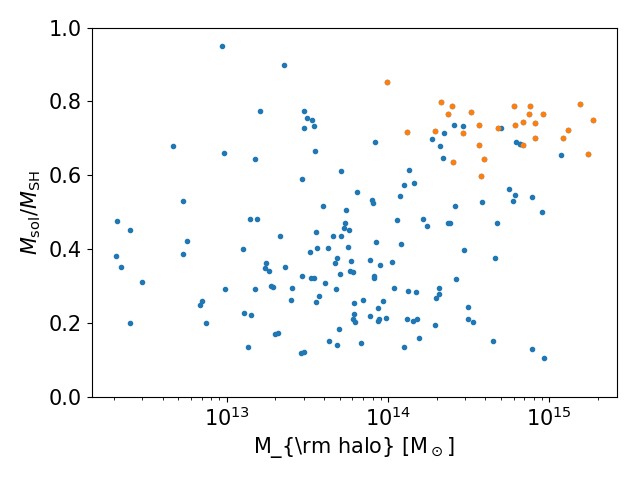

In [157]:
plt.subplots()
plt.plot(M_gal_arr, ratio_min_arr, '.')
plt.xscale('log')
plt.xlabel(r'M_{\rm halo} [M$_\odot$]')
plt.ylabel(r'$M_{\rm sol}/M_{\rm SH}$')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('./plots/ratio_Mhalo.pdf')

plt.plot(M_gal_sel_arr, ratio_min_sel_arr, '.')

<IPython.core.display.Javascript object>


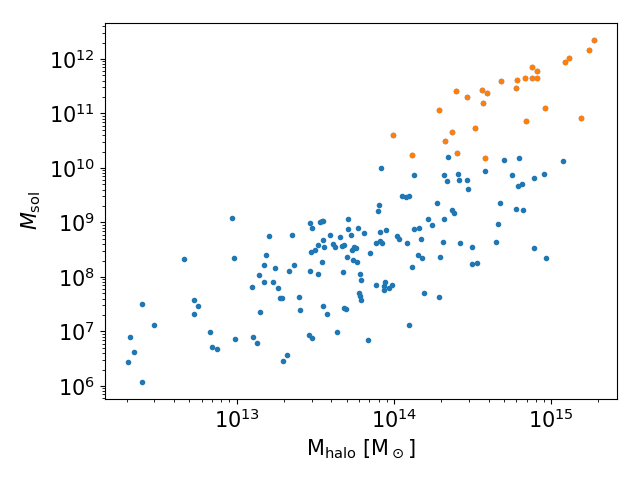

In [156]:
plt.subplots()
plt.plot(M_gal_arr, Msol_min_arr, '.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"M$_{\rm halo}$ [M$_\odot$]")
plt.ylabel(r"$M_{\rm sol}$")
#plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('./plots/Msol_Mhalo.pdf')

plt.plot(M_gal_sel_arr, Msol_min_sel_arr, '.')

# Investigate the size of numerical error

### for the bisection

In [ ]:
# plot out the rotational curves

<IPython.core.display.Javascript object>


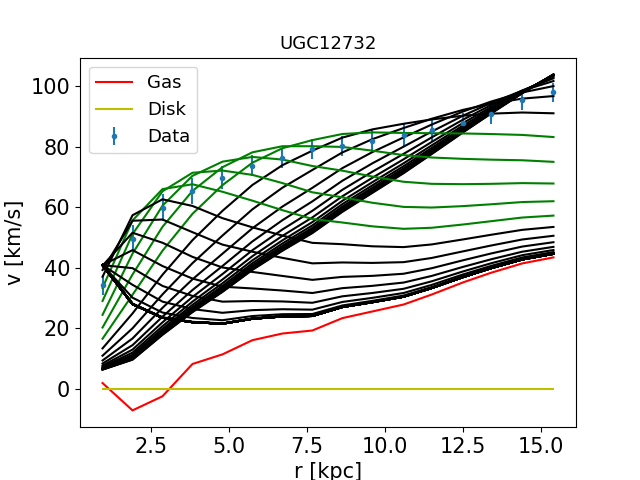

3.9978630726489537
4.009155488885304
3.999775421967491
4.003630524310578
4.001027525876905
3.992005833463085
4.008656312655444
4.0006354071151655
3.9971658900480893
4.002317407546646
4.006535782614692
3.996074376507698
4.006798672120742
4.003429334187191
3.995093166127261
4.0095441926833
3.9905393341101925
4.0071681966252966
3.998666163837847
4.005512400105251
3.9998698859348325
3.9948846038159505
4.008803542673433
4.008541675002346
4.0041475186872315
4.00164921534899
4.0014181421706
3.9968190495712963
3.99953484261556
3.999539325240771
3.9995394948800755
3.9995392216462253
3.999538833570061
3.999538522709302
3.999538315058791
3.999538186781121
3.9995381104989
3.9995380660277253
3.999538040378545
3.999538025672598
3.999538017268878
3.9995380124755684
3.9995380097444166
3.9995380081892224
3.999538007303929
3.9995380068000723
3.9995380065133372
3.9995380063502046
3.999538006257377
3.9995380062045434


Text(0.5,1,'UGC12732')

In [131]:
# observation: Burkert and sol are degenerate

plt.subplots()

# nonflat ones
name = 'UGC12732'

# flat ones
#name = 'NGC4013'
#name = 'NGC5371' ##
#name = 'NGC2683'
#name = 'UGC02487'
#name = 'NGC2841'; ##
#name = 'NGC7814';
#name = 'NGC4183';
#name = 'NGC0100';
gal = spc.findGalaxyByName(name, data)
Vtot = np.array([])
plt.errorbar(gal.R, gal.Vobs, gal.dVobs, fmt='.', label='Data')

path_wild = '../../results_bisection_04/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        if res_arr[0].gal.name == name:
            break
            
for i in range(len(res_arr)):
    m = res_arr[i].m
    M = res_arr[i].M_arr[1] # 2 sigma, 95% CL
    ups_bulg = 0
    ups_disk = 0
    chi2_val, Vtot = chi2.chi2_single_gal_overshooting(m, M, ups_disk, ups_bulg, gal, flg_Vtot=True)
    print(chi2_val)
    if 4e-24< m < 2e-23:
        fmt = 'g-'
    else:
        fmt = 'k-'
    plt.plot(gal.R, Vtot, fmt)#, label='Vtot')
    
plt.plot(gal.R, gal.Vgas,'r-', label='Gas')
plt.plot(gal.R, np.sqrt(ups_disk)*gal.Vdisk,'y-', label='Disk')    

plt.legend(loc='best')
plt.xlabel('r [kpc]')
plt.ylabel('v [km/s]')
plt.title('%s' %(gal.name))

### for the even grid scan

<IPython.core.display.Javascript object>


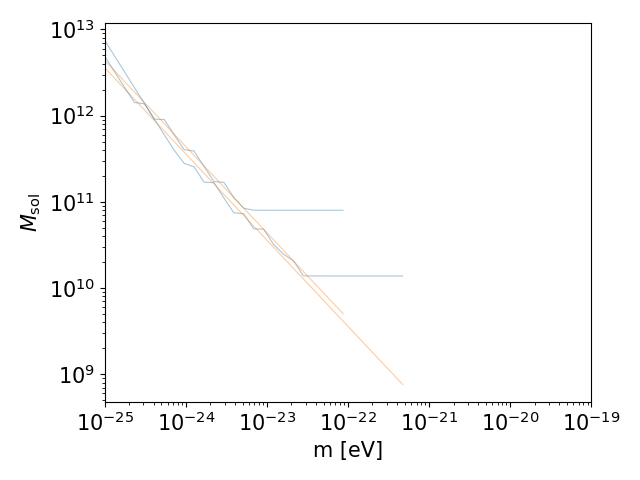

../../results_test11/result-NGC7814.dat
../../results_test11/result-NGC2841.dat


In [86]:
# investigate the minimum of Msol
bound_dct = {}
bound_range_dct = {}

plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel(r'$M_{\rm sol}$')
#plt.ylabel(r'$M_{\rm sol}/M_{\rm SH}$')
#plt.ylim(0.05, 10)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    #print(path)
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        M_plt_arr = np.array(M_plt_arr)
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        # debug filtering
#         if min(ratio_arr) < 0.7:
#             continue
        if m_plt_arr[np.argmin(ratio_arr)] > 1e-24:
            continue
        print(path)      
#        np.set_printoptions(precision=2)
#         print("m:", m_plt_arr)
#         print("Msol:", np.array(M_plt_arr))
#         print("Msh:", Msol_SH_arr)
            
        # end of debug filtering        
        mask = ratio_arr < ratio_upper * 10
        #plt.plot(m_plt_arr[mask], ratio_arr[mask], lw='0.8', color='C0', alpha=0.4)
        plt.plot(m_plt_arr[mask], M_plt_arr[mask], lw='0.8', color='C0', alpha=0.4)
        plt.plot(m_plt_arr[mask], Msol_SH_arr[mask], lw='0.8', color='C1', alpha=0.4)
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)
        
        #if res_arr[0].gal.name == 'NGC7814':
        #if res_arr[0].gal.name == 'NGC4183':
        if res_arr[0].gal.name == 'NGC2841':
            name = res_arr[0].gal.name
            break
            

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
#plt.fill_between(x, ylow, yup, alpha=0.3, color='r', zorder=0.1)
#plt.plot(x, y, 'k--', alpha=0.8)

m_test = np.logspace(-24, -22.8)
M_test = 8*(m_test/1e-24)**(-1/2)

m_test = np.logspace(-20.5, -19)
M_test = 2.*(m_test/m_test[0])
#plt.plot(m_test, M_test, '--', color='b', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

In [ ]:
# plot out the rotational curves

<IPython.core.display.Javascript object>


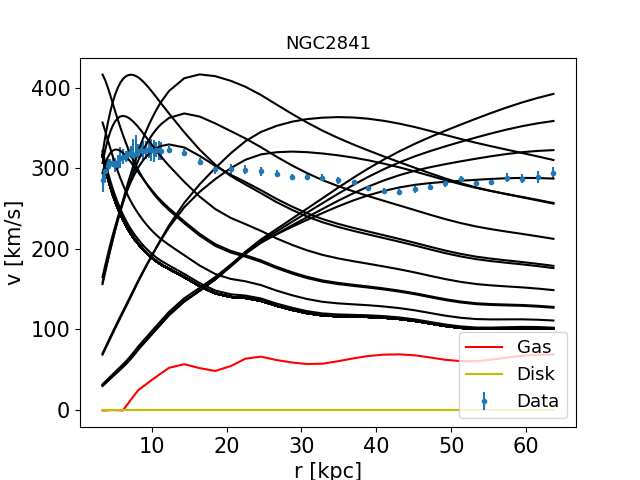

3121.7581475763063
1511.7205437074965
398.0252870355939
7.714351850077489
6353.578946592538
827.5358168459775
5282.876976116258
705.1628953599939
8.889063683698714
1956.90576395658
394.7453278966052
21.98856445356755
765.6511374623904
64.57510342404616
6.979514005620689
4.784824350015054
4.7590223458499485
4.75894823898053
4.758948036971302
4.758948128538283
4.758948460279623
4.758948773982097
4.758948996929924
4.758949138596001
4.75894922403783
4.758949274222382
4.75894930328476
4.7589493199857245
4.7589493295413
4.758949334995632
4.758949338104817
4.758949339875518
4.7589493408836345
4.758949341457482
4.7589493417840245
4.758949341969858
4.758949342075563
4.758949342135616
4.758949342169822
4.758949342189584
4.758949342200605
4.758949342206833
4.758949342210501
4.758949342212524
4.758949342213625
4.758949342214437
4.7589493422147084
4.758949342214947
4.7589493422151135
4.758949342215157


Text(0.5,1,'NGC2841')

In [87]:
# observation: Burkert and sol are degenerate

plt.subplots()

#name = 'NGC7814';
#name = 'NGC4183';
#name = 'NGC0100';
gal = spc.findGalaxyByName(name, data)
Vtot = np.array([])
plt.errorbar(gal.R, gal.Vobs, gal.dVobs, fmt='.', label='Data')

for i in range(len(m_plt_arr)):
    DM_profile = 'sol'
    m = m_plt_arr[i]
    M = M_plt_arr[i]
    ups_bulg = 0
    ups_disk = 0

#     chi2_val, Vtot = chi2.chi2_single_gal(m, M, 0, 0, ups_disk, ups_bulg, gal, 
#                                           flg_Vtot=True, DM_profile=DM_profile, combine_mode='adding')
    chi2_val, Vtot = chi2.chi2_single_gal_overshooting(m, M, ups_disk, ups_bulg, gal, flg_Vtot=True)
    print(chi2_val)
    #plt.plot(gal.R, Vtot, 'k-')#, label='Vtot')
    
#     if np.abs(m - 1.33e-25) <0.1e-25:
#        plt.plot(gal.R, Vtot, 'k-')#, label='Vtot')
    plt.plot(gal.R, Vtot, 'k-')#, label='Vtot')
    
plt.plot(gal.R, gal.Vgas,'r-', label='Gas')
plt.plot(gal.R, np.sqrt(ups_disk)*gal.Vdisk,'y-', label='Disk')    

plt.legend(loc='best')
plt.xlabel('r [kpc]')
plt.ylabel('v [km/s]')
plt.title('%s' %(gal.name))

In [38]:
# debug scan.analyze()

path_wild = '../../results_test11/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    #print(path)
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        scan.analyze(res_arr, res_arr[0].sigma_lvl)
        
        if res_arr[0].gal.name == name:
            break


In [39]:
res_arr[0].__dict__

{'M_arr': array([1.00e+05, 1.53e+05, 2.33e+05, 3.56e+05, 5.43e+05, 8.29e+05,
        1.26e+06, 1.93e+06, 2.95e+06, 4.50e+06, 6.87e+06, 1.05e+07,
        1.60e+07, 2.44e+07, 3.73e+07, 5.69e+07, 8.69e+07, 1.33e+08,
        2.02e+08, 3.09e+08, 4.71e+08, 7.20e+08, 1.10e+09, 1.68e+09,
        2.56e+09, 3.91e+09, 5.96e+09, 9.10e+09, 1.39e+10, 2.12e+10,
        3.24e+10, 4.94e+10, 7.54e+10, 1.15e+11, 1.76e+11, 2.68e+11,
        4.09e+11, 6.25e+11, 9.54e+11, 1.46e+12, 2.22e+12, 3.39e+12,
        5.18e+12, 7.91e+12, 1.21e+13, 1.84e+13, 2.81e+13, 4.29e+13,
        6.55e+13, 1.00e+14]),
 'M_contours': [4838180704943.74,
  4890126000818.436,
  4920770208208.131,
  4942629009173.929,
  4959650858658.762,
  5012900323075.202],
 'chi2_arr': array([0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.0

In [40]:
result = scan.analyze(res_arr, [1], debug=True, debug_bp=1)

m=1.33e-25, M_arr: [1.00e+05 1.53e+05 2.33e+05 3.56e+05 5.43e+05 8.29e+05 1.26e+06 1.93e+06
 2.95e+06 4.50e+06 6.87e+06 1.05e+07 1.60e+07 2.44e+07 3.73e+07 5.69e+07
 8.69e+07 1.33e+08 2.02e+08 3.09e+08 4.71e+08 7.20e+08 1.10e+09 1.68e+09
 2.56e+09 3.91e+09 5.96e+09 9.10e+09 1.39e+10 2.12e+10 3.24e+10 4.94e+10
 7.54e+10 1.15e+11 1.76e+11 2.68e+11 4.09e+11 6.25e+11 9.54e+11 1.46e+12
 2.22e+12 3.39e+12 5.18e+12 7.91e+12 1.21e+13 1.84e+13 2.81e+13 4.29e+13
 6.55e+13 1.00e+14]
chi2=[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 3.68e+03 9.95e+04 4.42e+05 1.20e+06 2.78e+06 5.94e+06 1.18e+07
 2.13e+07 3.50e+07]


<IPython.core.display.Javascript object>


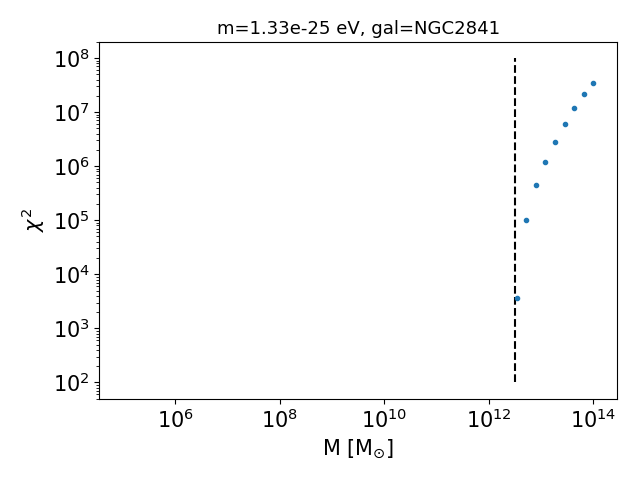

In [42]:
plt.subplots()
plt.plot(result.M_arr, result.chi2_arr, '.')
plt.vlines(result.M_contours, 1e2, 1e8, linestyles='--', color='k')
plt.title("m=%.2e eV, gal=%s" %(result.m, result.gal.name))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('M [M$_{\odot}$]')
plt.ylabel('$\chi^2$')
plt.tight_layout()